Linformer: Self-Attention with Linear Complexity

https://arxiv.org/abs/2006.04768


#### Transformer and Self-Attention
Transformerは、Multi-Head Self-Attention(MHA)のアイデアに基づいて構築されています。これにより、モデルは異なる位置にある情報に注意を向けることができます。MHAは次のように定義されます。

$$
MultiHead(Q,K,V)=Concat(head_1,head_2,\cdots,head_h)W^Q
$$

ここで、$Q,K,V \in R^{n×d_m}$は入力埋め込み行列、$n$はシーケンス長、$d_m$は埋め込み次元、$h$はヘッド数です。 各ヘッドは次のように定義されます。

$$
head_i=Attention(QW_i^Q,KW_i^K,VW_i^V)=softmax\bigg[\frac{QW_i^Q(KW_i^K)^T}{\sqrt{d_k}} \bigg]VW_i^V
$$

ここで、$W_i^Q、W_i^K \in R^{d_m×d_k} 、W_i^V \in R^{d_m×d_v} 、W^O \in R^{hd_v×dm}$は学習された行列であり、$d_k,d_v$は射影部分空間の次元です。 今回は$d_k$と$d_v$を区別せず、単に$d$を使用します。

2つめの式で定義されたself-attentionは、context mapping行列$P \in R^{n×n}$を参照します。Transformerは$P$を使用して、系列内のすべてのトークンの組み合わせに基づいて、特定のトークンの入力コンテキストをキャプチャします。 ただし、$P$の計算にはコストがかかります。 時間と空間の複雑さで$O(n^2)$である2つの$n × d$行列を乗算する必要があります。系列の長さに対するこの二次依存性は、Transformerのボトルネックになっています。

### Self-Attention is Low Rank

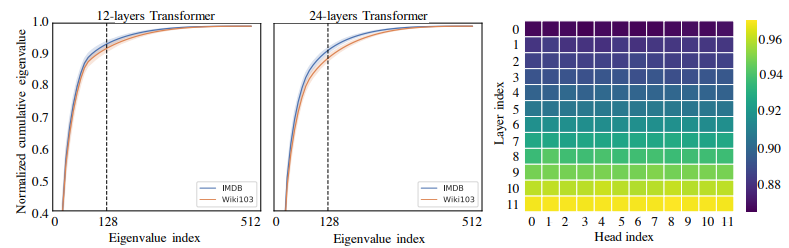

最初に、context mapping行列$P$のスペクトル分析を提供します。2つのタスク: Wiki103でのマスク言語モデリングタスク(Merity et al., 2016)とIMDBでの分類タスク(Maas et al., 2011)で事前学習済みTransformerモデル、RoBERTa-base(1層スタックTransformer)とRoBERTa-large(24層スタックTransformer)を使用します(Liu et al., 2019 )。図1(左)では、モデルのさまざまなレイヤーとさまざまなヘッドにわたって特異値分解を$P$に適用し、10,000センテンスで平均化された正規化された累積特異値をプロットします。結果は、各レイヤー、ヘッド、およびタスクにわたって明確なロングテールスペクトル分布を示しています。これは、行列$P$のほとんどの情報が、最初のいくつかの最大の特異値から復元できることを意味します。図1(右)では、128番目に大きい特異値(512のうち)で正規化された累積特異値のヒートマップをプロットします。上位層のスペクトル分布は下位層よりも歪んでいることがわかります。つまり、上位層では、より多くの情報が最大の特異値に集中し、$P$のランクが低くなります。

**Theorem 1.** (self-attention is low rank)
任意の$Q, K, V \in R^{n×d}$および$W_i^Q, W_i^K, W_i^V \in R^{d×d}$、および行列$VW_i^V$の任意の列ベクトル$w \in R_n$に対して、次のような低ランク行列$\tilde{P} \in R^{n×n}$が存在します。
$$
Pr(|\tilde{P}w^T-Pw^T|<\epsilon |Pw^T|)>1-o(1)\ and\ rank(\tilde{P})=\Theta(\log (n))
$$

ここでcontext mapping行列$P$は(2)式で定義されるものである。

### Model

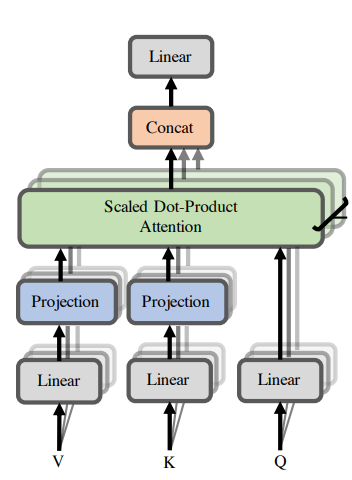

このセクションでは、系列長に対して線形な時間とメモリの複雑さでcontext mapping$P・VW_i^V$を計算できるようにする新しいself-attentionメカニズムを提案します。 提案されたlinear self-attention(図2)の主なアイデアは、keyとvalueを計算するときに 2つの線形射影行列 $E_i,F_i \in R^{n×k}$を追加することです。 最初に、元の$(n × d)$次元のkeyとvalueのレイヤー$KW_i^K$と$VW_i^V$を$(k × d)$次元に投影します。次に、scaled dot-attentionを使用して、$(n × k)$次元のcontext mapping行列$\bar{P}$を計算します。

$$
\begin{align}
\bar{head_i}&=Attention(QW_i^Q,E_iKW_i^K,F_iVW_i^V)\\
&=softmax\bigg(\frac{QW_i^Q(E_iKW_i^K)^T}{\sqrt{d_k}} \bigg)F_iVW_i^V
\end{align}
$$

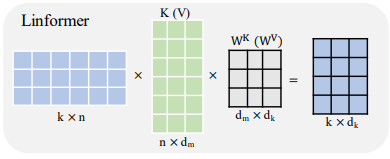

最後に、$\bar{P}·(F_iVW_i^V)$を使用して各$head_i$のコンテキスト埋め込みを計算します。 $k \ll n$のような非常に小さな射影次元$k$を選択できれば、メモリとスペースの消費を大幅に削減できます。 次の定理は、$k = O(d/2)$($n$に依存しない)の場合、誤差を伴うlinear self-attentionを使用して$P·VW_i^V$を近似できることを示しています。

**Theorem 2.**  (Linear self-attention)
任意の$Q_i, K_i, V_i \in R^{n×d}$および$W_i^Q, W_i^K, W_i^V \in R^{d×d}$に対して、$k=\min\{\Theta(9d\log (d)/\epsilon^2),5\Theta(\log (n)/\epsilon^2)\}$であれば、行列$QW_i^Q(E_iKW_i^K)^T/\sqrt{d_k}$の任意のベクトル$w$に対して、次の式を満たす$E_i,F_i\in R^{n×k}$が存在する。

$$
Pr(|softmax(wE_i^T)F_iVW_i^V-softmax(w)VW_i^V|)\leq |softmax(w)||VW_i^V|)>1-o(1)
$$

#### Parameter sharing between projections
レイヤーとヘッド全体で線形射影行列$E_i,F_i$のパラメーターを共有できます。 具体的には、次の3つのレベルの共有を実験しました。
• headごとの共有: 各層について、すべての頭$i$にわたって$E_i = E$および$F_i = F$となるように、2つの射影行列$E$および$F$を共有します。
• keyとvalueの共有: keyとvalueのプロジェクションを共有するという追加の制約を加えて、ヘッドワイズ共有を行います。レイヤーごとに、すべてのhead$i$にわたる各key値射影行列に対して$E_i = F_i = E$となるような単一の射影行列$E$ を作成します。
• レイヤーごとの共有: すべてのレイヤー、すべてのhead、およびkeyとvalueの両方で単一の射影行列$E$を使用します。 たとえば、12層、12headのスタックTransformerモデルでは、headごとの共有、key/valueの共有、およびレイヤーごとの共有により、それぞれ24、12、および1つの異なる線形射影行列が導入されます。